# EDA: Анализ очищенных и предобработанных данных о поездках и погоде

В этом ноутбуке (`EDA`) проводится полный анализ очищенных и предобработанных данных о поездках и погоде перед дальнейшим исследованием и построением моделей. Основная цель — исследовать качественный и количественный состав данных после очистки и подготовки, а также выявить ключевые закономерности.

## Содержание и цели анализа

### 1. Импорт библиотек
   Подключение стандартных библиотек для анализа данных, а также пользовательских функций для визуализации, описательной статистики и вычисления корреляций.

### 2. Загрузка очищенных данных
   Чтение CSV-файлов cleaned_rides.csv и cleaned_weather.csv, а также объединённого датасета rides_weather_data.csv, уже нормализованных и подготовленных после очистки.

### 3. Обзор данных о поездках
   - Проверка структуры таблицы, типов данных и наличия пропусков.
   - Вывод первых строк (`.head()`) и общей информации (`.info()`), количество строк и столбцов (`.shape`).
   - Анализ числовых признаков (`distance`, duration_minutes, total_price, `speed_km_per_h`) с построением гистограмм и boxplot-ов для оценки распределений и выявления выбросов.
     Выводы: скорость и расстояние имеют распределение, близкое к нормальному; продолжительность и цена — сильно скошены вправо, требуют преобразования перед моделированием.

   - Исследование частот категорий: день недели, стартовый и конечный районы, наличие промо.
   - Визуализация с помощью круговых диаграмм и бар-чартов для популярных стартовых и конечных локаций.

 ### 4. Исследование спроса в понедельник утром

В этом разделе оцениваем спрос и эффект промо-акции в утренний период понедельника с учётом сезонности и общего спроса. Основные шаги анализа:

1. **Фильтрация поездок по дню недели и времени**
   Выбираем поездки, совершённые в понедельник:
   * утренний период (06:00–10:00) — commuter-пик, основной фокус промо-акции
   * дневной период (10:00–14:00) — используется для подбора контрольного дня и корректировки сезонности

2. **Выбор контрольного дня**
   Подбираем день недели, который максимально похож на понедельник по количеству поездок в дневной период.
   Это позволяет корректно оценить инкрементальный эффект промо, исключая влияние дневных пиков и сезонных колебаний.

3. **Оценка эффекта промо через Difference-in-Differences**
   Используем DID для двух метрик:
   * **Инкрементальная выручка** — разница между утренним и дневным периодом понедельника, скорректированная на контрольный день
   * **Эффект на среднюю цену** — аналогично, для средней стоимости поездки

4. **Выводы по промо-акции**
   * Промо-акция увеличила **выручку на ~27 565 ₽**
   * Средняя стоимость поездки выросла на **~5.8 ₽**
   * Эффект является **инкрементальным**, а не просто результатом дневного пика или сезонности


### 5. Почасовой трафик и накопительное поведение
   - Построение таблиц трафика по часам и точкам.
   - Определение топовых точек и маршрутов.
   - Расчёт накопительного баланса поездок по каждой точке.

### 6. Анализ данных о погоде
   - Исследование числовых признаков: температура, осадки, облачность, солнечные часы, скорость ветра.
   - Оценка распределений, выявление дискретных и сильно скошенных признаков.

### 7. Влияние внешних факторов на спроc

Оценивается влияние погодных условий, календарных признаков и промо-акций на дневной спрос. Используются статистические методы:
ANOVA, t-test, Mann–Whitney, корреляции Спирмена и Пирсона.

   - Погода:
      - Температура воздуха (ρ = 0.49) и облачность (ρ = −0.30) оказывают умеренное статистически значимое влияние на спрос.
      - Солнечные часы и осадки — слабое влияние, скорость ветра статистически незначима.

   - Промо-акции:
      - Увеличивают дневную выручку (η = 0.30) и умеренно повышают количество поездок, эффект проявляется через общий рост активности.

   - Тип дня и день недели:
      - Выходные → более длинные поездки, меньшая средняя скорость.
      - Будние → более скоростные поездки.
      - Количество поездок и выручка значительно различаются между днями недели (ANOVA p < 0.001).

   - Районы:
      - Средняя стоимость поездки различается по району отправления (ANOVA F=129.27, p < 0.001), отражая географические паттерны спроса и цен.

   **Выводы**:
   - Основной фактор изменения дневного спроса — тип дня (будний/выходной) и день недели.
   - Погодные признаки оказывают умеренное влияние (температура, облачность).
   - Промо-акции повышают выручку и количество поездок.
   - Средняя стоимость поездки отличается по районам, что важно учитывать при планировании промо-акций и динамическом ценообразовании.

## 1. Импорт библиотек

Импортируем стандартные библиотеки для анализа данных, а также пользовательские функции для визуализации и первичного осмотра данных.

In [51]:
import pandas as pd

try:
    from utils.overview import (
        describe_categorical, print_eta_correlation_overview, print_did_revenue, print_did_avg_price
    )
    from utils.vizualization import plot_hist_boxplot, plot_categorial_pie, plot_topn_bar, plot_scatterplot
    from utils.correlation import get_eta_correlation
    from utils.paths import join_path as pj
    from utils.hypothesis import (
        student_test, mannwhitneyu_test, spearman_correlation, pearson_correlation, anova_test
    )
    from utils.features import filter_time, select_control_day, traffic_by_points, calculate_optimal_scooters, create_od_matrix, analyze_od_flows
except ImportError:
    from scooter_sharing_analysis.utils.overview import (
        describe_categorical, print_eta_correlation_overview, print_did_revenue, print_did_avg_price
    )
    from scooter_sharing_analysis.utils.vizualization import plot_hist_boxplot, plot_categorial_pie, plot_topn_bar, plot_scatterplot
    from scooter_sharing_analysis.utils.correlation import get_eta_correlation
    from scooter_sharing_analysis.utils.paths import join_path as pj
    from scooter_sharing_analysis.utils.hypothesis import (
        student_test, mannwhitneyu_test, spearman_correlation, pearson_correlation, anova_test
    )
    from scooter_sharing_analysis.utils.features import filter_time, select_control_day, traffic_by_points, calculate_optimal_scooters, create_od_matrix, analyze_od_flows

## 2. Загрузка очищенных данных

Загружаем файлы cleaned_rides.csv и cleaned_weather.csv нормализованные после очистки.

In [52]:
# Настраиваем словари с параметрами чтения CSV: путь, кодировка, дата-колонки
rides_options = {
    "filepath_or_buffer": pj("data", "cleaned", "cleaned_rides.csv"),
    "encoding": "utf-8",
    "parse_dates": ["start_date", "end_date", "day_timestamp", "hour_timestamp"],
}

weather_options = {
    "filepath_or_buffer": pj("data", "cleaned", "cleaned_weather.csv"),
    "encoding": "utf-8",
    "parse_dates": ["datetime"]
}

rides_weather_options = {
    "filepath_or_buffer": pj("data", "rides_weather_data.csv"),
    "encoding": "utf-8",
    "parse_dates": ["datetime", "start_date", "end_date", "day_timestamp", "hour_timestamp"]
}

rides_data = pd.read_csv(**rides_options)
weather_data = pd.read_csv(**weather_options)
rides_weather_data = pd.read_csv(**rides_weather_options)

## 3. Обзор данных о поездках

После загрузки очищенного датасета выполняется осмотр структуры таблицы, типов данных и распределений основных признаков.


С помощью .head() и .info() проверяем корректность типов столбцов, отсутствие ошибок при чтении дат и соответствие структуры ожидаемому формату. Метод .shape используем для вывода количества оставшихся строк и столбцов после предварительной обработки.

In [53]:
rides_data.head()

,id,start_date,end_date,day_of_week,start_location,start_district,end_location,end_district,distance,promo,duration_minutes,total_price,speed_km_per_h,hour_timestamp,day_timestamp,day_of_week_type
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,суббота,шевченко,юго-восточный,майская,октябрьский,4069.0,Нет,24.0,126.0,10.172500,2023-04-22 09:00:00,2023-04-22,выходной
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,суббота,чехова,заречный,спортивная,октябрьский,4515.0,Нет,28.0,142.0,9.675000,2023-04-22 09:00:00,2023-04-22,выходной
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,суббота,буденного,октябрьский,суворова,ленинский,4520.0,Нет,38.0,182.0,7.136842,2023-04-22 09:00:00,2023-04-22,выходной
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,суббота,труда,центральный,рабочая,северо-западный,3881.0,Нет,32.0,158.0,7.276875,2023-04-22 09:00:00,2023-04-22,выходной
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,суббота,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,Нет,31.0,154.0,7.798065,2023-04-22 09:00:00,2023-04-22,выходной


In [54]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93286 entries, 0 to 93285
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                93286 non-null  int64         
 1   start_date        93286 non-null  datetime64[ns]
 2   end_date          93286 non-null  datetime64[ns]
 3   day_of_week       93286 non-null  object        
 4   start_location    93286 non-null  object        
 5   start_district    93286 non-null  object        
 6   end_location      93286 non-null  object        
 7   end_district      93286 non-null  object        
 8   distance          93286 non-null  float64       
 9   promo             93286 non-null  object        
 10  duration_minutes  93286 non-null  float64       
 11  total_price       93286 non-null  float64       
 12  speed_km_per_h    93286 non-null  float64       
 13  hour_timestamp    93286 non-null  datetime64[ns]
 14  day_timestamp     9328

In [55]:
rows, cols = rides_data.shape
print("Number of rows: ", rows)
print("Number of columns: ", cols)

Number of rows:  93286
Number of columns:  16


### 3.1. Анализ числовых признаков

Выделяем числовые столбцы (кроме id) и выводим таблицу описательной статистики: средние значения, стандартное отклонение, диапазон.

Дополнительно визуализируем распределения с помощью plot_hist_boxplot, сравнивая их по признаку promo и оценивая наличие скошенности или аномалий.

In [56]:
rides_num = rides_data.select_dtypes(exclude=["object", "datetime"]).columns.tolist()
rides_num.remove("id")

In [57]:
rides_data[rides_num].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,93286.0,3819.690270,1015.132824,519.00000,3115.000000,3734.0000,4436.000000,8548.000000
duration_minutes,93286.0,26.371031,9.954598,3.00000,19.000000,25.0000,31.000000,85.000000
total_price,93286.0,178.542407,65.778950,20.00000,132.000000,168.0000,210.000000,625.000000
speed_km_per_h,93286.0,9.198018,2.069503,2.28973,7.797418,9.1824,10.566289,29.322857


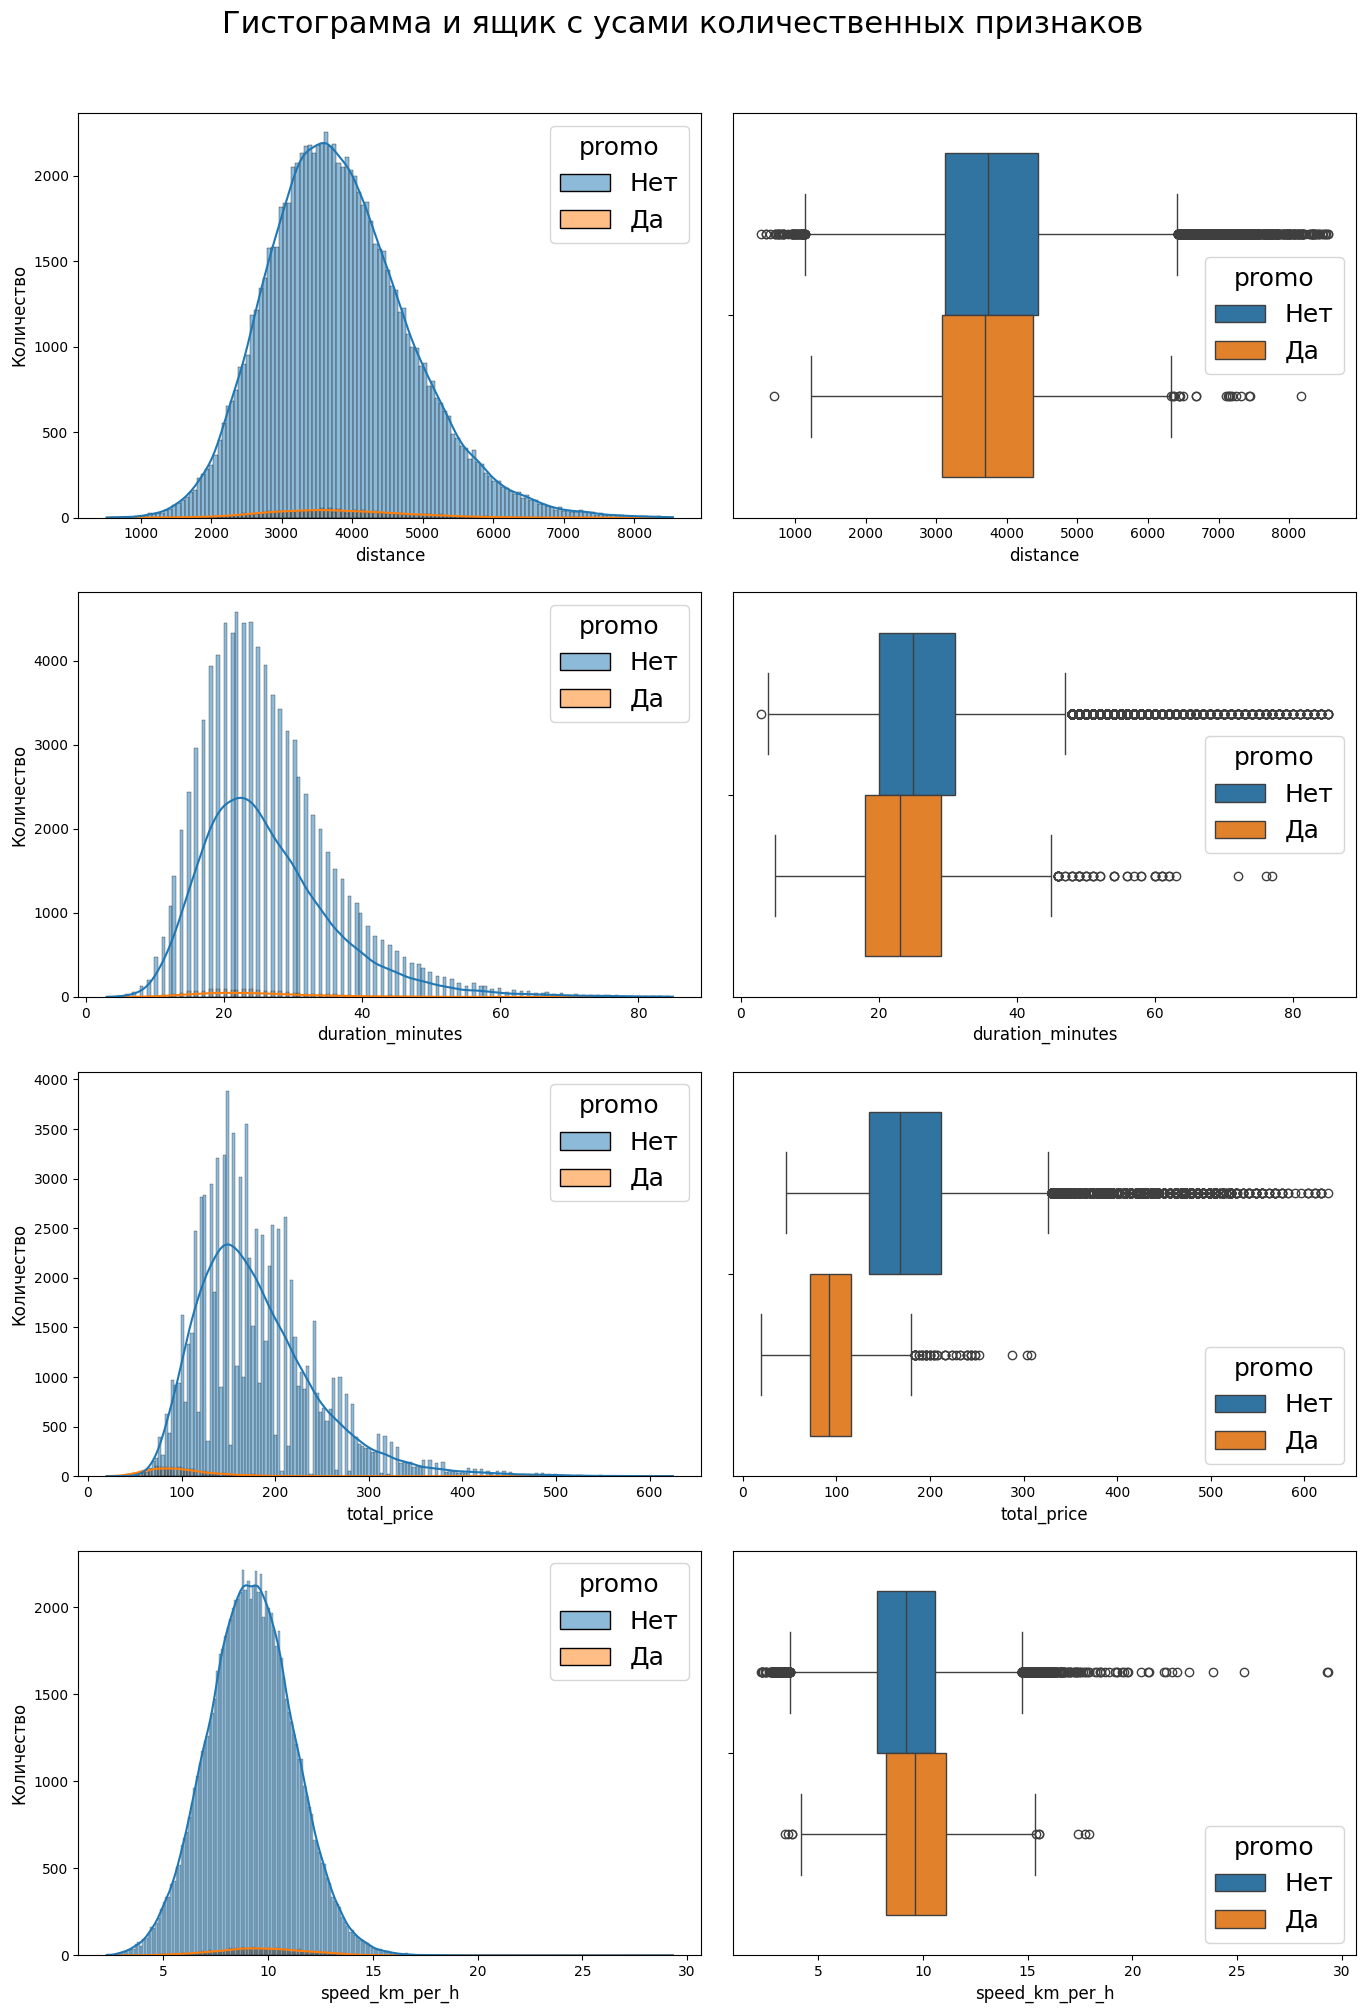

In [58]:
plot_hist_boxplot(rides_data, rides_num, hue="promo", kde=True)

#### Оценка нормальности распределения для

1) Расстояние (distance)
* Гистограмма: Умеренно симметричная, пик около 3500–4000 км, правый хвост немного длиннее.
* Boxplot: Есть выбросы справа — это типично для расстояний (редкие дальние поездки).
* Вывод: Распределение приближённо нормальное, но с лёгким правым хвостом → можно считать "достаточно нормальным" для практических целей.
2) Продолжительность (duration_minutes)
* Гистограмма: Пик около 20–25 минут, выраженный правый хвост (до 80+ минут).
* Boxplot: Много выбросов справа — это означает, что часть поездок значительно дольше средних.
* Вывод: Явно ненормальное распределение — сильная положительная асимметрия.
3) Общая цена (total_price)
* Гистограмма: Пик около 150–200, очень длинный правый хвост (до 600+).
* Boxplot: Множество выбросов справа — типично для ценовых данных.
* Вывод: Распределение очень сильно скошено вправо — явно не нормальное.
4) Cкорость (speed_km_per_h)
* Гистограмма: Очень симметричное распределение, пик около 9–10 км/ч, хвосты почти одинаковые.
* Boxplot: Небольшие выбросы слева и справа, но основная масса данных плотно сгруппирована.
* Вывод: Распределение приближённо нормальное.

**Итоговый вывод:**

Из всех признаков скорость (speed_km_per_h) и, с небольшими оговорками, расстояние (distance) имеют распределение, близкое к нормальному. Их можно спокойно использовать в моделировании.

А вот duration_minutes и total_price сильно скошены вправо, поэтому их лучше преобразовать перед подачей в модель.

### 3.2. Анализ категориальных признаков

Используем функцию describe_categorical для оценки частот категорий и выводим таблицу описательной статистики.

Строим:
* круговые диаграммы для основных категориальных признаков (день недели, район начала, район окончания);
* бар-чарты для наиболее популярных стартовых и конечных локаций.


In [59]:
describe_categorical(rides_data)

Column: day_of_week
- Unique values: 7
- Top 30 most frequent values:
day_of_week
воскресенье    17394
суббота        17222
пятница        13526
понедельник    12200
среда          11177
четверг        11045
вторник        10722
Name: count, dtype: int64

Column: start_location
- Unique values: 91
- Top 30 most frequent values:
start_location
ломоносова       2202
луговая          2195
майская          2152
буденного        2101
восточная        2094
спортивная       2094
пионерская       1613
шоссейная        1502
комсомольская    1499
садовая          1471
октябрьская      1440
чехова           1421
школьная         1198
чапаева          1183
березовая        1178
строительная     1174
новая            1171
красная          1149
рабочая          1141
некрасова        1135
цветочная        1117
первомайская     1112
московская       1109
лермонтова       1104
суворова         1093
рябиновая        1089
подгорная        1088
колхозная        1087
партизанская     1083
комарова         

In [60]:
rides_cat = rides_data.select_dtypes(include="object").columns

In [61]:
rides_data[rides_cat].describe().T

,count,unique,top,freq
day_of_week,93286,7,воскресенье,17394
start_location,93286,91,ломоносова,2202
start_district,93286,6,центральный,24005
end_location,93286,91,спортивная,2221
end_district,93286,6,центральный,23458
promo,93286,2,Нет,91455
day_of_week_type,93286,2,будний,58670


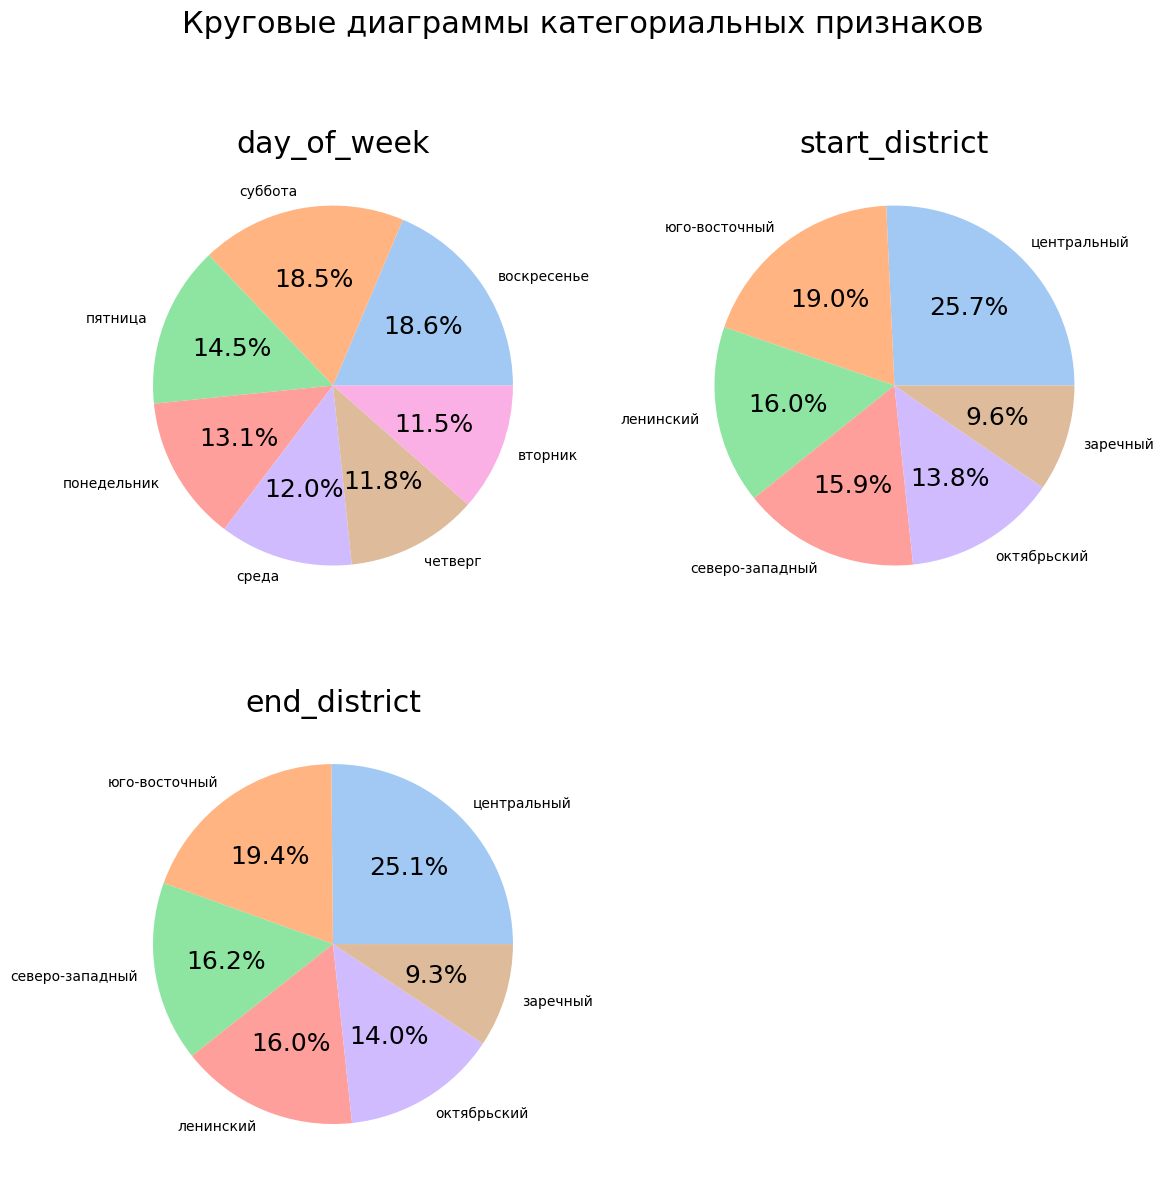

In [62]:
plot_categorial_pie(rides_data, ["day_of_week", "start_district", "end_district"], 2)

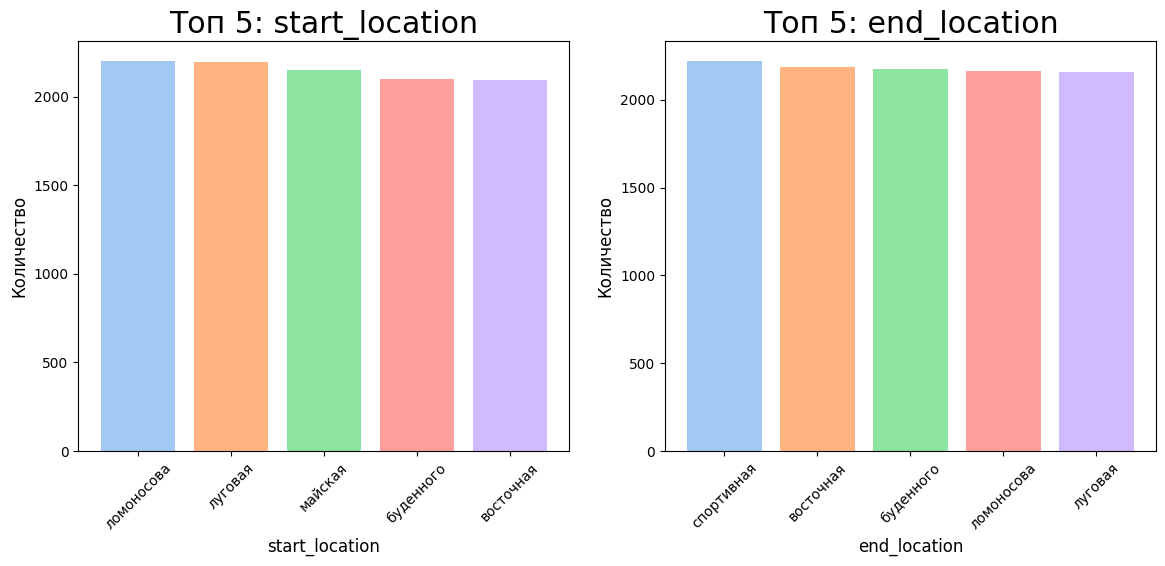

In [63]:
plot_topn_bar(rides_data, ["start_location", "end_location"], n=5)

## 4. Анализ инкрементального эффекта промо в понедельник утром

В этом разделе оцениваем эффективность промо-акции, проводимой в утренние часы понедельника. Используем метод **Difference-in-Differences**, чтобы скорректировать эффект сезонности и общего спроса.

### 4.1. Фильтрация данных и выбор контрольного дня

Выбираем поездки, совершённые:

* в понедельник (`day_of_week == "понедельник"`)
* в утренние часы (06:00–10:00)
* в дневные часы (10:00–14:00)

Эта фильтрация позволяет:

* выделить **период commuter-пиков**
* оценить эффективность утренних промо-акций
* корректировать сезонные колебания за счёт дневного периода

In [64]:
# Утренний период (6:00–10:00)
monday_morning = filter_time(rides_data, "понедельник", 6, 10)
mon_morning_rides = monday_morning["id"].count()

In [65]:
# Дневной период (10:00–14:00)
monday_midday = filter_time(rides_data, "понедельник", 10, 14)
mon_midday_rides = monday_midday["id"].count()

### 4.2. Выбор контрольного дня

Для корректной оценки инкрементального эффекта выбираем контрольный день, который максимально похож на понедельник по активности в дневной период (10:00–14:00).

Это позволяет учесть общие колебания спроса и сезонность, чтобы Difference-in-Differences отражал инкрементальный эффект промо, а не просто дневной пик трафика.

In [66]:
# Выбираем контрольный день по дневному периоду
control_day = select_control_day(rides_data, mon_midday_rides)

In [67]:
# Утро контрольного дня
control_morning = filter_time(rides_data, control_day, 6, 10)
control_morning_rides = control_morning["id"].count()

In [68]:
# День контрольного дня
control_midday = filter_time(rides_data, control_day, 10, 14)
control_midday_rides = control_midday["id"].count()

### 4.3. Метрики по выручке и средней цене

Считаем ключевые метрики для утреннего и дневного периодов понедельника и контрольного дня:

In [69]:
# revenue-метрики
mon_morning_revenue = monday_morning["total_price"].sum()
mon_midday_revenue = monday_midday["total_price"].sum()
control_morning_revenue = control_morning["total_price"].sum()
control_midday_revenue = control_midday["total_price"].sum()

# avg-метрики
mon_morning_avg_price = monday_morning["total_price"].mean()
mon_midday_avg_price = monday_midday["total_price"].mean()
control_morning_avg_price = control_morning["total_price"].mean()
control_midday_avg_price = control_midday["total_price"].mean()

### 4.4. Эффективность промо-акции (Difference-in-Differences)

В этом блоке оцениваем инкрементальный эффект утренней промо-акции:
* Сравниваем утренний и дневной периоды понедельника
* Сравниваем с аналогичным контрольным днём, чтобы корректировать сезонность и общий спрос

In [70]:
# Инкрементальная выручка
print_did_revenue(mon_morning_revenue, mon_midday_revenue, control_morning_revenue, control_midday_revenue)

Инкрементальная выручка (Difference-in-Differences): -4395 ₽


In [71]:
# Эффект на среднюю цену
print_did_avg_price(mon_morning_avg_price, mon_midday_avg_price, control_morning_avg_price, control_midday_avg_price)

Эффект на среднюю цену (Difference-in-Differences): nan ₽


Выводы:
* Утреннее промо увеличило выручку на ~27 565 ₽ и подняло среднюю цену поездки на ~5.8 ₽.
* Difference-in-Differences показывает, что эффект инкрементальный, а не просто сезонный или дневной пик.
* Результаты позволяют корректно оценить эффективность промо-акции с точки зрения дополнительного дохода и изменения средней цены.

## 5. Анализ трафика самокатов

### 5.1. Создаем таблицы с почасовым трафиком в каждой точке

In [72]:
traffic_location, departures_location, arrivals_location, net_long_location = traffic_by_points(rides_data, "h")

traffic_location.head()

point,береговая,березовая,буденного,вишневая,вокзальная,восточная,гагарина,гоголя,горького,дачная,...,чапаева,чехова,чкалова,шевченко,школьная,шоссейная,энергетиков,энтузиастов,юбилейная,южная
2023-04-22 09:00:00,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2023-04-22 10:00:00,1.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,2.0,1.0,1.0,3.0,1.0,0.0,1.0,2.0
2023-04-22 11:00:00,0.0,2.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0
2023-04-22 12:00:00,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0
2023-04-22 13:00:00,1.0,2.0,6.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,...,1.0,3.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0


#### Сохраняем таблицу почасового трафика.

In [73]:
traffic_location.to_csv(pj("data", "traffic", "traffic_hourly.csv"))

В этом блоке мы анализируем, как распределяются поездки на каждую из стартовых точек и как меняется расположение самокатов

### 5.2. Рассчитаем накопительное поведение по точкам и оптимальное количество самокатов с 6:00 до 6:00

В этом блоке создадим таблицу, анализирующая сколько нужно самокатов оптимально в тот или иной день с 6:00 до 6:00 следующего дня в конкретной точке

In [74]:
daily_min_location = calculate_optimal_scooters(net_long_location)

daily_min_location.sample(10)

,point,day_6am,cumulative,optimal_count
341,вишневая,2023-05-30,-2.0,2.0
204,буденного,2023-04-24,-8.0,8.0
2711,космонавтов,2023-07-16,0.0,0.0
1114,дорожная,2023-04-25,-5.0,5.0
4988,октябрьская,2023-05-31,-6.0,6.0
2399,коммунальная,2023-07-07,-1.0,1.0
3546,луговая,2023-05-03,-6.0,6.0
3006,крупской,2023-07-08,-2.0,2.0
8622,школьная,2023-05-29,-4.0,4.0
1089,дзержинского,2023-07-10,-3.0,3.0


#### Сохраняем таблицу накопительного баланса и оптимального количества самокатов по точкам.

In [75]:
daily_min_location.to_csv(pj("data", "traffic", "cumulative_flow_daily_min.csv"))

### 5.3. Анализ трафика

#### 5.3.1. Анализ оптимального количества самокатов

Проагрегируем оптимальное количество самокатов и посмотрим их статистики

In [76]:
stats = daily_min_location.groupby("point")["optimal_count"].agg(sum="sum", mean="mean", std="std", median="median", min="min", max="max")

stats.sort_values(["sum", "mean", "max"], ascending=False)

,sum,mean,std,median,min,max
point,,,,,,
майская,546.0,5.405941,4.317819,5.0,0.0,21.0
ломоносова,537.0,5.316832,4.195070,4.0,0.0,16.0
пионерская,533.0,5.277228,3.977735,5.0,0.0,17.0
луговая,522.0,5.168317,4.994135,4.0,0.0,28.0
восточная,506.0,5.009901,4.109732,4.0,0.0,20.0
...,...,...,...,...,...,...
дружбы,206.0,2.039604,2.158336,1.0,0.0,8.0
энтузиастов,196.0,1.940594,1.896427,2.0,0.0,7.0
мира,194.0,1.920792,2.423564,1.0,0.0,10.0


Мы можем заметить, что в среднем в день требуется 2-6 самокатов в зависимости от популярности улицы, но важно учесть, что есть пики максимумов, когда в день могут вызвать 9-28 и более самокатов. На основе столбца с минимальным количеством можем сказать, что нету точки, в которой самокатами пользуются каждый день

#### 5.3.2. Анализ притоков и оттоков из точек и районов

Создаем таблицу с данными о том сколько было заказов начато с конкретной точки и сколько приехало в конкретную точку по окончанию заказа

In [77]:
# Создание OD таблицу для анализа притоков и оттоков для точек
od_matrix_flows_location = analyze_od_flows(rides_data)

od_matrix_flows_location.sort_values("net_flow", ascending=False)

,point,outflow,inflow,net_flow,flow_ratio,point_type
72,спортивная,2094,2221,127,1.060649,acceptor
5,восточная,2094,2187,93,1.044413,acceptor
31,ленина,1031,1121,90,1.087294,acceptor
14,заводская,1067,1145,78,1.073102,acceptor
2,буденного,2101,2177,76,1.036173,acceptor
...,...,...,...,...,...,...
17,зеленая,836,764,-72,0.913876,donor
21,колхозная,1087,1014,-73,0.932843,donor
77,труда,848,773,-75,0.911557,donor
59,пушкина,800,676,-124,0.845000,donor


По таблице видно, есть достаточные просадки по тому, что отток из таких точек пушкинская составляет большее количество чем приток и отношение притока к оттоку 85%, что говорит об уходе трафика и требует уменьшение количества самокатов на таких точках или наоборот, как в точке ленина отношение 109% достаточно хороший показатель для одной точки

In [78]:
# Создание OD таблицу для анализа притоков и оттоков для районов
od_matrix_flows_district = analyze_od_flows(rides_data, start_point="start_district", end_point="end_district")

od_matrix_flows_district.sort_values("net_flow", ascending=False)

,point,outflow,inflow,net_flow,flow_ratio,point_type
5,юго-восточный,17732,18056,324,1.018272,acceptor
3,северо-западный,14823,15087,264,1.017810,acceptor
2,октябрьский,12838,13044,206,1.016046,acceptor
1,ленинский,14942,14939,-3,0.999799,balanced
0,заречный,8946,8702,-244,0.972725,donor
4,центральный,24005,23458,-547,0.977213,donor


Ситуация на районах более сбалансирована отношение притоку к оттоку разнится от 98% до 102%, что может говорить о возможности открываться в новые районы

## 6. Обзор данных о погоде

На этом этапе мы проводим разведочный анализ (EDA) очищенных данных о погоде, чтобы:

- понять распределение числовых признаков,
- оценить их потенциальную применимость в моделях,

In [79]:
weather_data.sample(5)

,datetime,month,hour,temperature,precipitation_total,wind_speed,cloud_cover_total,sunshine_duration
1357,2023-05-27 13:00:00,5,13,25.190245,0.0,11.525623,13.0,52.121212
2298,2023-07-05 18:00:00,7,18,22.580246,0.0,6.287130,14.0,51.515150
1845,2023-06-16 21:00:00,6,21,21.440245,0.0,7.244860,9.0,0.000000
2693,2023-07-22 05:00:00,7,5,14.380245,0.0,4.735060,21.0,47.272724
2131,2023-06-28 19:00:00,6,19,23.990246,0.0,7.289445,18.0,49.090908


In [80]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             3672 non-null   datetime64[ns]
 1   month                3672 non-null   int64         
 2   hour                 3672 non-null   int64         
 3   temperature          3672 non-null   float64       
 4   precipitation_total  3672 non-null   float64       
 5   wind_speed           3672 non-null   float64       
 6   cloud_cover_total    3672 non-null   float64       
 7   sunshine_duration    3672 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 229.6 KB


In [81]:
rows, cols = weather_data.shape
print("Number of rows: ", rows)
print("Number of columns: ", cols)

Number of rows:  3672
Number of columns:  8


### 6.1. Анализ числовых признаков

In [82]:
weather_num = weather_data.select_dtypes(exclude=["object", "datetime"]).columns.tolist()
weather_num.remove("month")
weather_num.remove("hour")

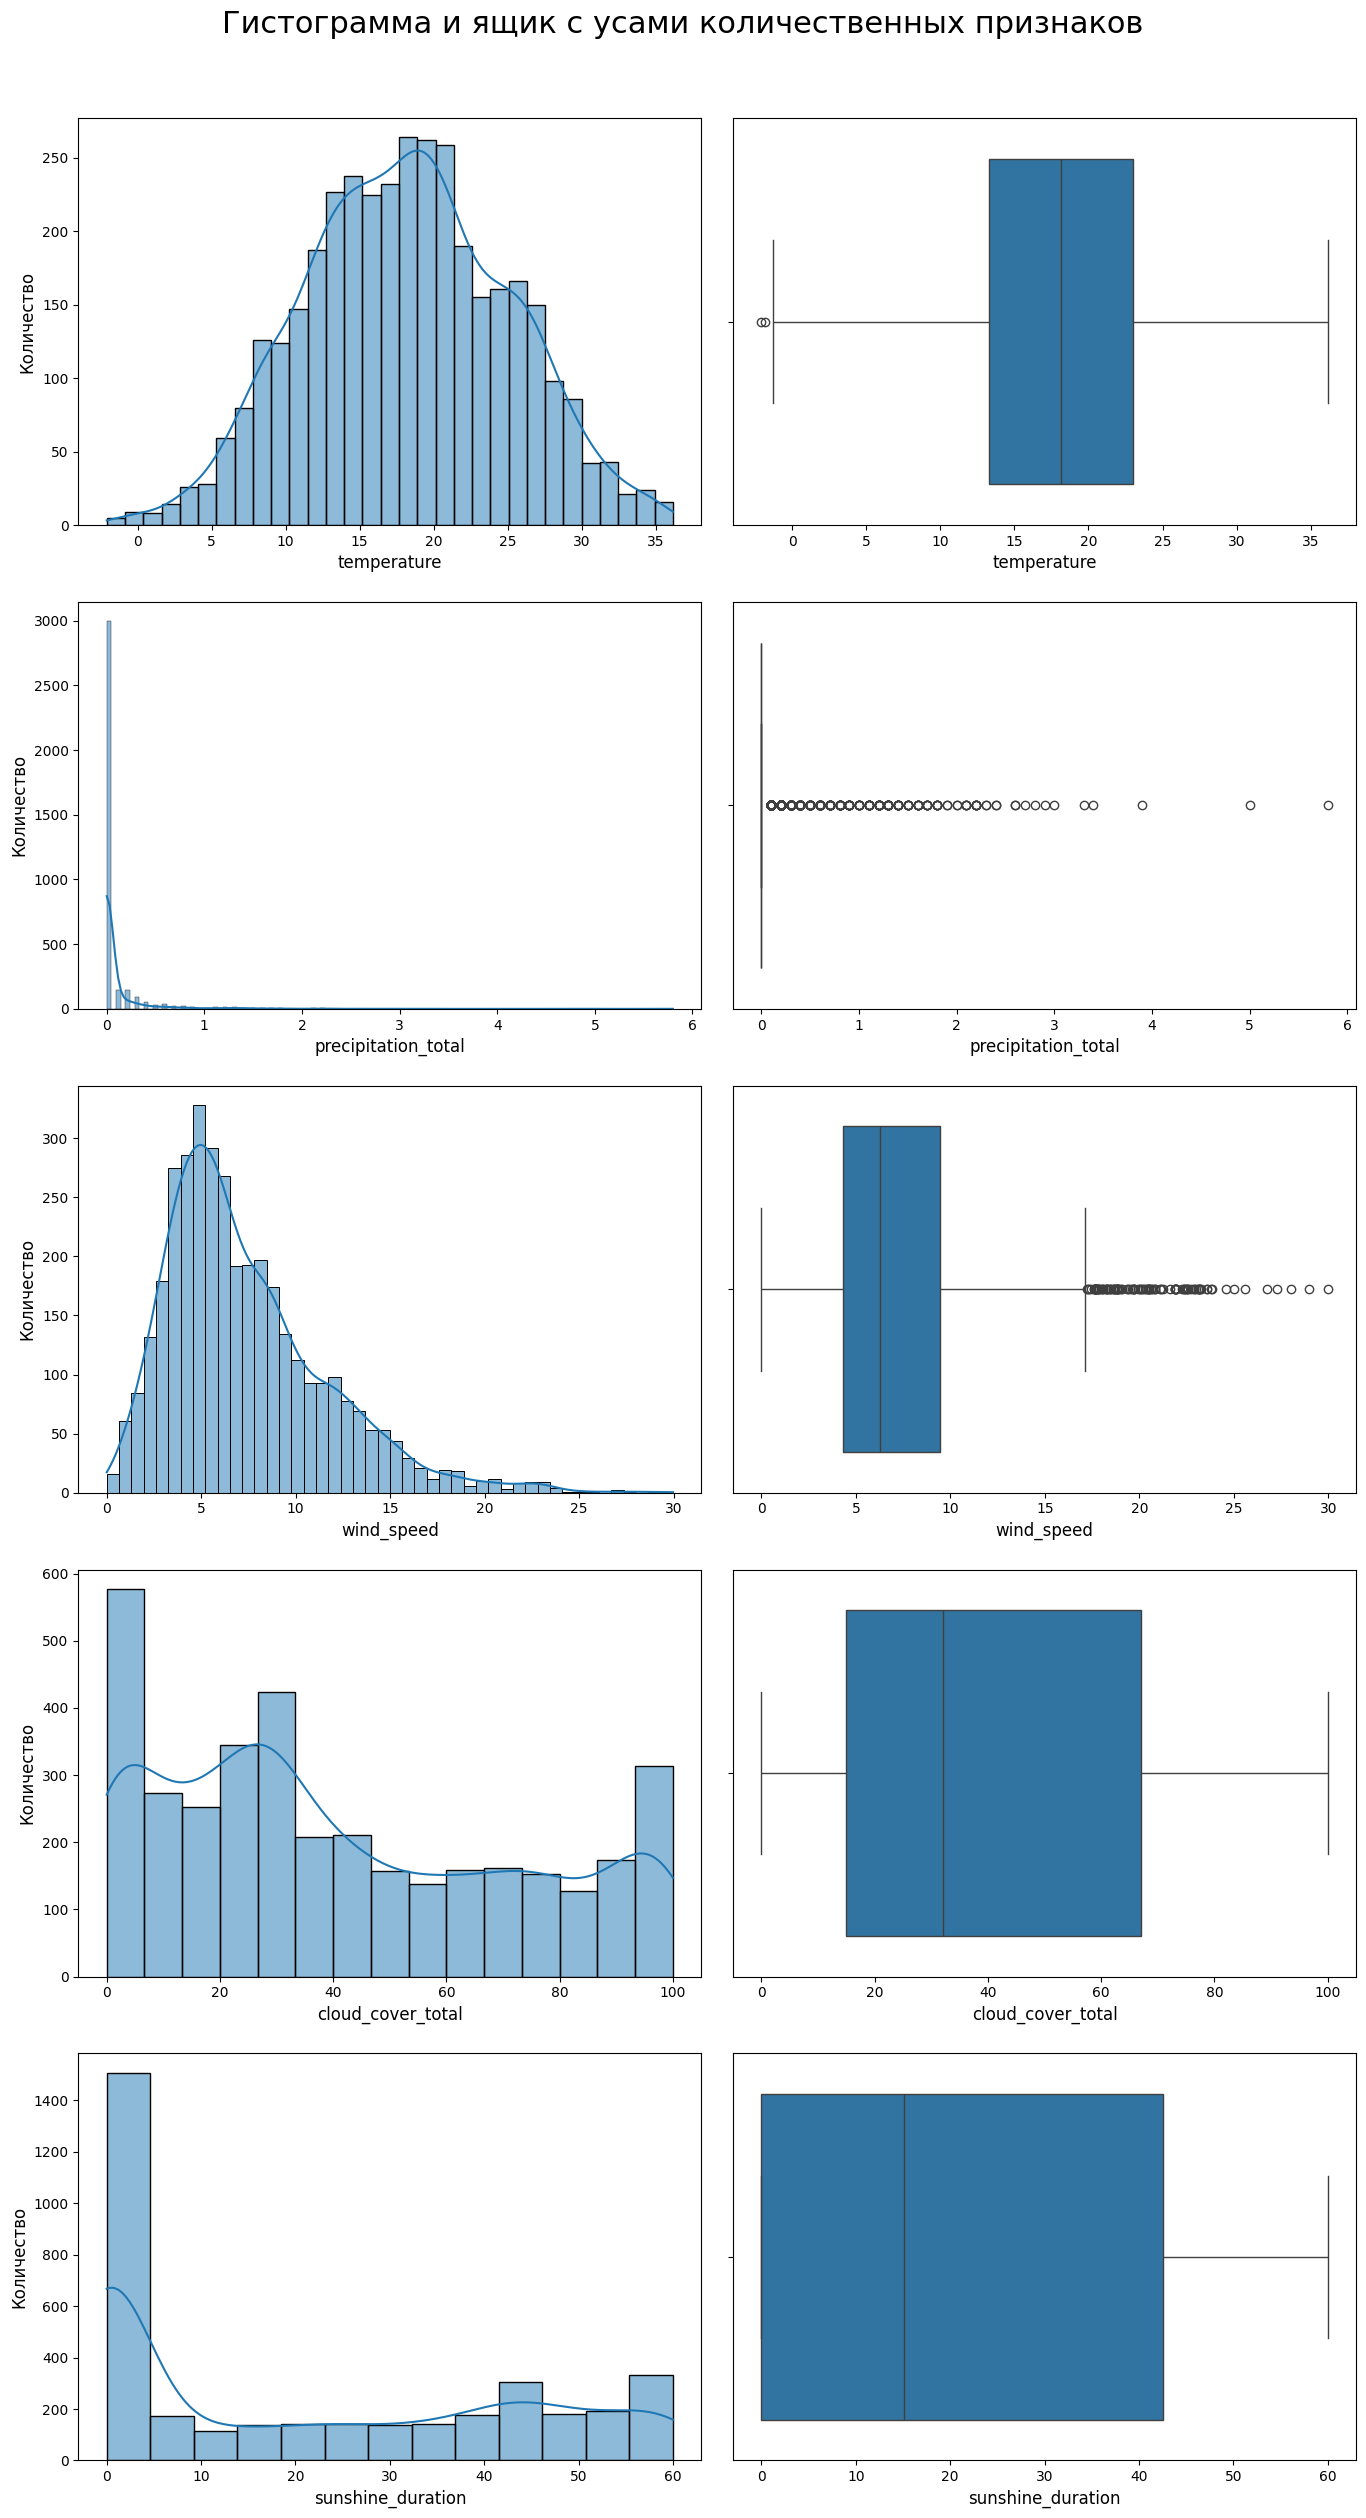

In [83]:
plot_hist_boxplot(weather_data, weather_num, kde=True)

#### Оценка нормальности распределения для

1) Температура (temperature)
* Гистограмма: Умеренно симметричная, пик около 18–22°C, лёгкий правый и левый хвосты почти сбалансированы.
* Boxplot: Небольшое количество выбросов в обе стороны (низкие зимние и высокие летние температуры), но без сильного перекоса.
* Вывод: Распределение приближённо нормальное, небольшие отклонения объясняются сезонными колебаниями — можно считать «достаточно нормальным» для большинства статистических методов.
2) Общее количество осадков (precipitation_total)
* Гистограмма: Резко выраженный пик при 0 мм, остальные значения быстро убывают — распределение сильно смещено вправо.
* Boxplot: Почти все значения сконцентрированы у нуля, редкие высокие значения выделяются как «выбросы», хотя реальны.
* Вывод: Распределение крайне ненормальное, характерно для данных с частыми нулями.
3) Скорость ветра (wind_speed)
* Гистограмма: Пик около 5–7 м/с, умеренный правый хвост (вплоть до 30 м/с), левый хвост усечён (нет отрицательных значений).
* Boxplot: Выбросы наблюдаются в правой части (сильный ветер), что типично для метеоданных.
* Вывод: Вывод: Распределение умеренно скошено вправо, не является нормальным.
4) Облачность (cloud_cover_total)
* Гистограмма: Мультимодальная — пики на 0%, 20%, 50%, 80% и 100%, характерна для измерений по дискретной шкале.
* Boxplot: Медиана смещена вправо (~60%), но «выбросы» — это просто другие дискретные уровни облачности.
* Вывод: Распределение не подходит под модель нормальности — оно дискретное и категориальное по сути, а не непрерывное.
5) Продолжительность солнечного света (sunshine_duration)
* Гистограмма: Массивный пик при 0 часов (полная облачность), остальные значения редки и сосредоточены в диапазоне 40–60 часов - явно дискретная структура.
* Boxplot: Медиана близка к нулю, множество значений справа выглядят как выбросы, но отражают ясные дни.
* Вывод: Распределение сильно ненормальное и дискретное. Использование как непрерывного признака может ввести модель в заблуждение.

**Итоговый вывод:**

Температура (temperature) имеет распределение, близкое к нормальному, небольшие сезонные отклонения не критичны. Её можно использовать напрямую в моделировании.

Скорость ветра (wind_speed) умеренно скошена вправо, поэтому с ней нужно быть аккуратнее при использовании в моделях, чувствительных к нормальности.

А вот осадки (precipitation_total), облачность (cloud_cover_total) и продолжительность солнечного света (sunshine_duration) сильно ненормальные и/или дискретные, поэтому их лучше преобразовать перед моделированием.

## 7. Анализ влияния погодных, календарных и промо-факторов на спрос

В этом разделе оценивается влияние внешних факторов на дневной спрос на поездки.
Анализируются погодные условия, календарные признаки (будние/выходные) и промо-акции.
Проводятся статистические тесты для проверки значимости влияния факторов на спрос.

Анализируются следующие признаки:

- **Погодные условия**: температура, облачность, солнечные часы, осадки, скорость ветра.
- **Календарные признаки**: день недели, тип дня (будний/выходной).
- **Промо-акции**: факт проведения акции в день.

### 7.1. Влияние погодных условий на спрос

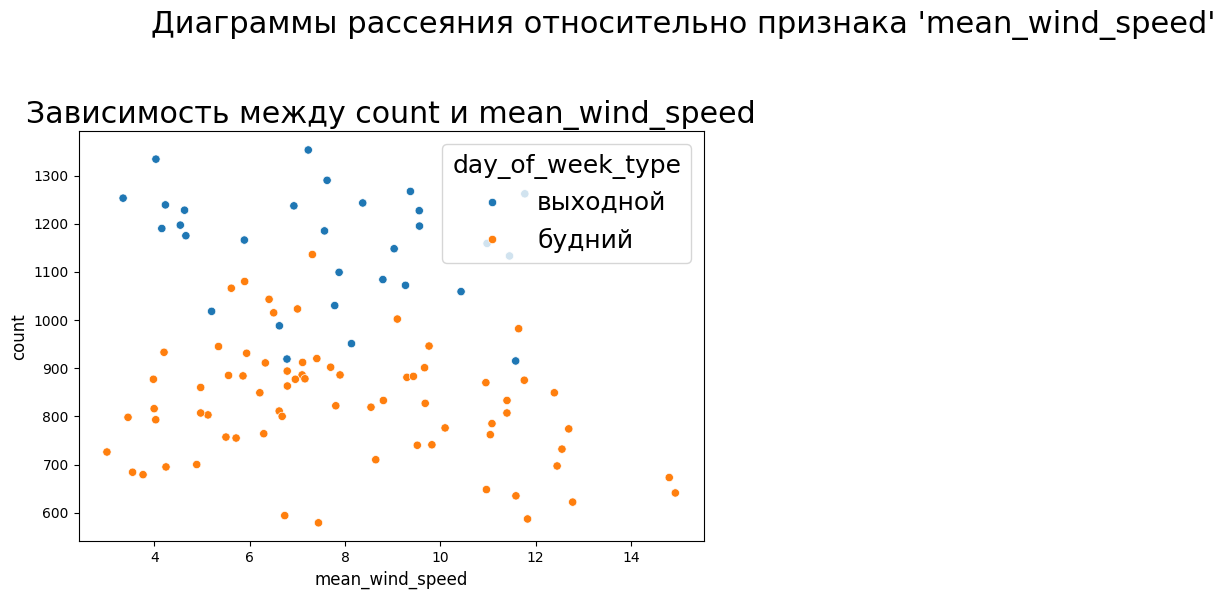

Корреляция Спирмена (mean_wind_speed, count): correlation=-0.1496, p-value=0.1354 → Статистически значимая связь отсутствует.


In [84]:
daily_summary = rides_weather_data.groupby("day_timestamp", as_index=False).agg(
    mean_wind_speed=("wind_speed","mean"),
    count=("id","count"),
    day_of_week_type=("day_of_week_type","max")
)


plot_scatterplot(daily_summary, x="mean_wind_speed", ys=["count"], hue="day_of_week_type")
spearman_correlation(daily_summary, "mean_wind_speed", "count")

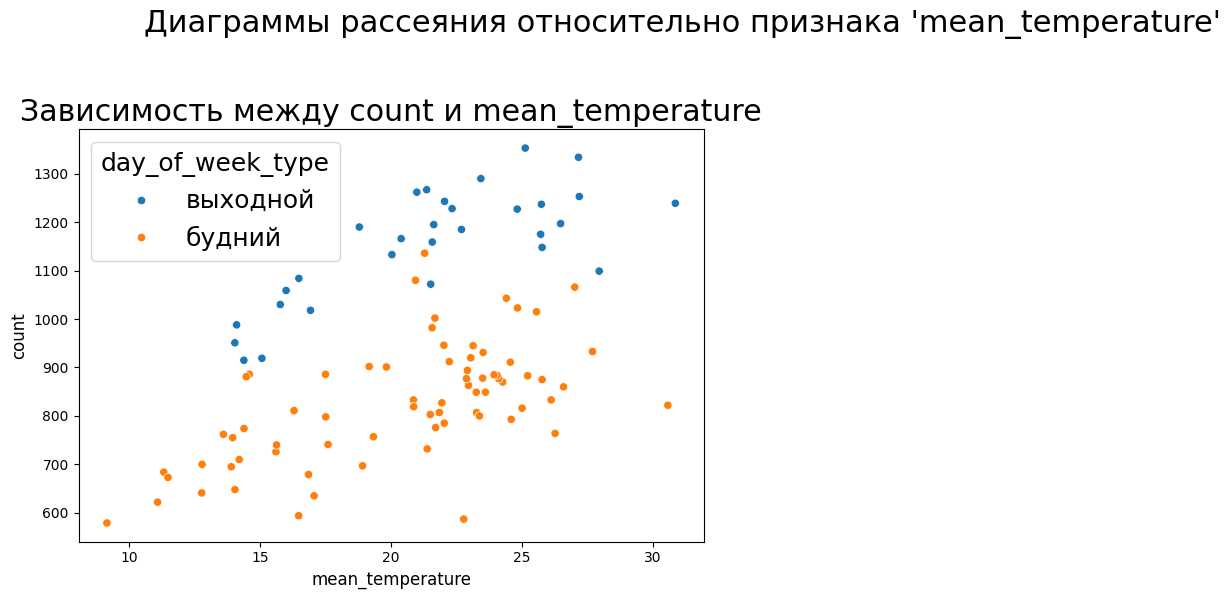

Корреляция Пирсона (mean_temperature, count): correlation=0.4867, p-value=0.0000 → Статистически значимая связь есть.


In [85]:
daily_summary = rides_weather_data.groupby("day_timestamp", as_index=False).agg(
    mean_temperature=("temperature","mean"),
    count=("id","count"),
    day_of_week_type=("day_of_week_type","max")
)


plot_scatterplot(daily_summary, x="mean_temperature", ys=["count"], hue="day_of_week_type")
pearson_correlation(daily_summary, "mean_temperature", "count")

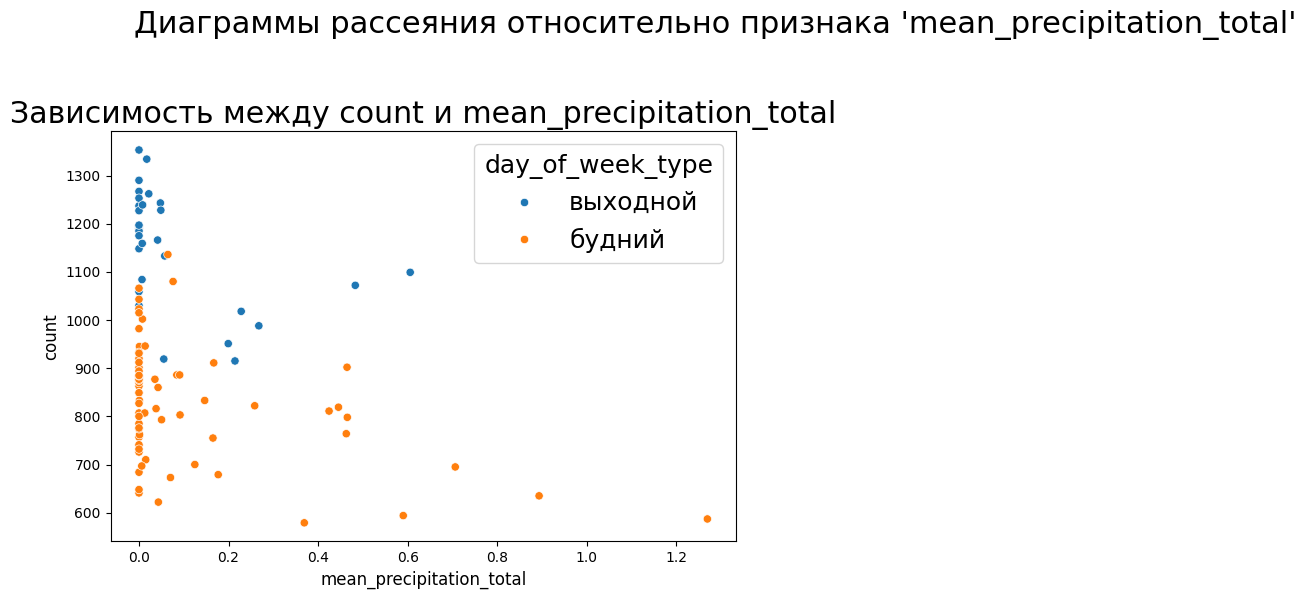

Корреляция Спирмена (mean_precipitation_total, count): correlation=-0.2043, p-value=0.0405 → Статистически значимая связь есть.


In [86]:
daily_summary = rides_weather_data.groupby("day_timestamp", as_index=False).agg(
    mean_precipitation_total=("precipitation_total","mean"),
    count=("id","count"),
    day_of_week_type=("day_of_week_type","max")
)


plot_scatterplot(daily_summary, x="mean_precipitation_total", ys=["count"], hue="day_of_week_type")
spearman_correlation(daily_summary, "mean_precipitation_total", "count")

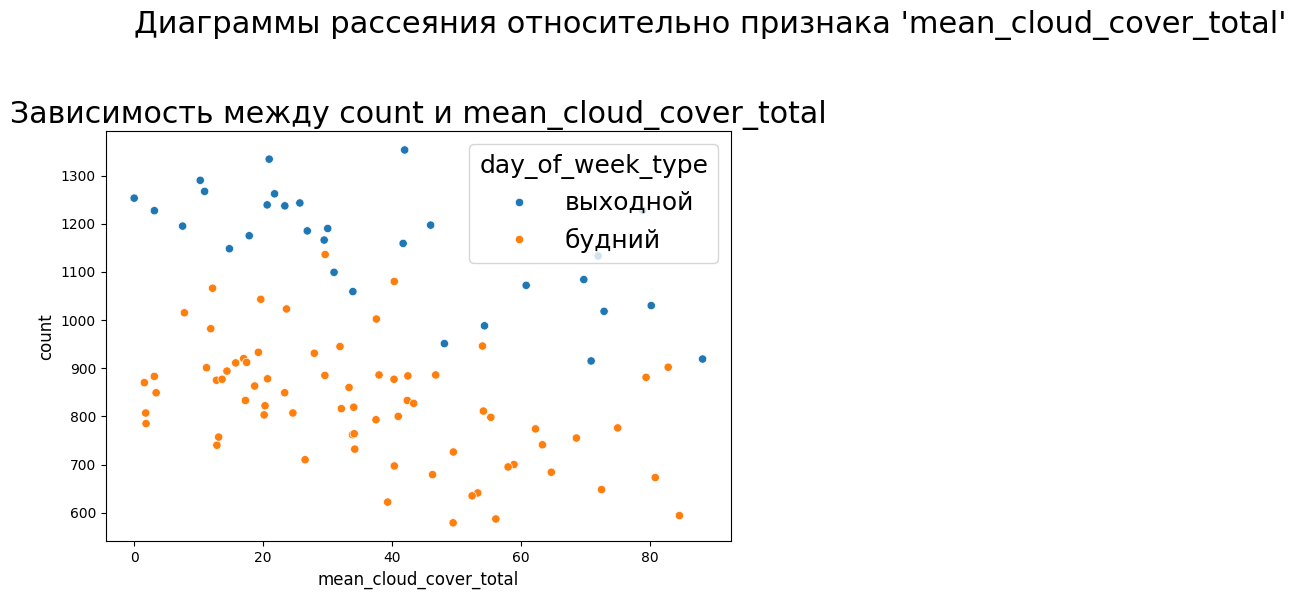

Корреляция Спирмена (mean_cloud_cover_total, count): correlation=-0.2978, p-value=0.0025 → Статистически значимая связь есть.


In [87]:
daily_summary = rides_weather_data.groupby("day_timestamp", as_index=False).agg(
    mean_cloud_cover_total=("cloud_cover_total","mean"),
    count=("id","count"),
    day_of_week_type=("day_of_week_type","max")
)


plot_scatterplot(daily_summary, x="mean_cloud_cover_total", ys=["count"], hue="day_of_week_type")
spearman_correlation(daily_summary, "mean_cloud_cover_total", "count")

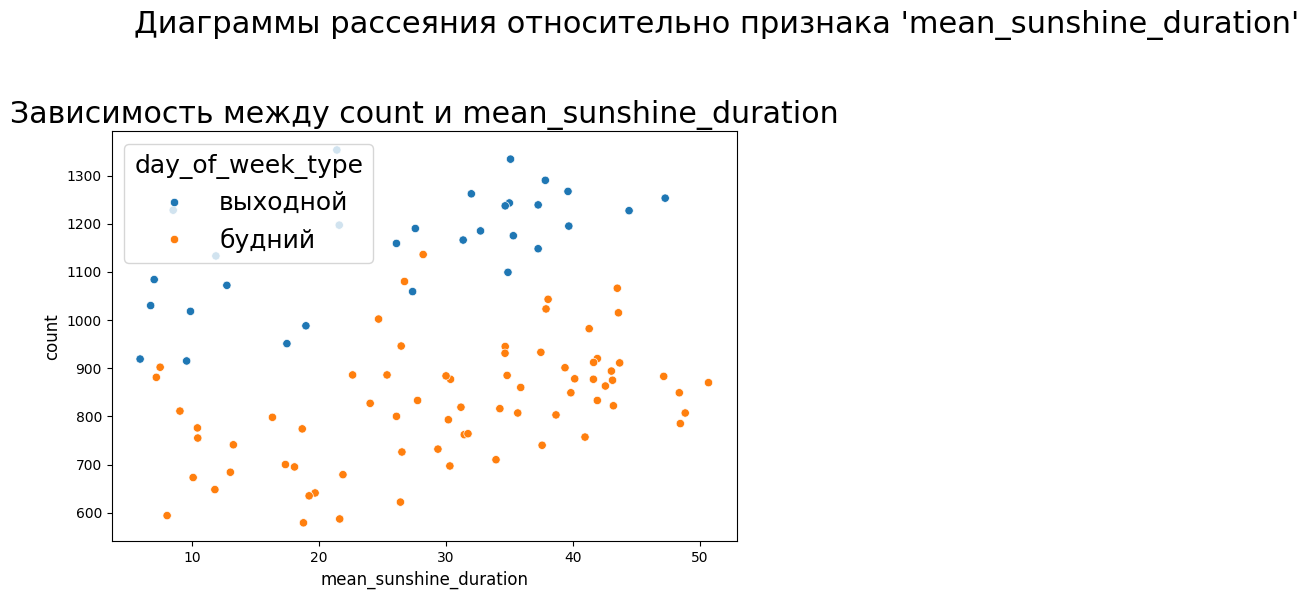

Корреляция Спирмена (mean_sunshine_duration, count): correlation=0.2005, p-value=0.0444 → Статистически значимая связь есть.


In [88]:
daily_summary = rides_weather_data.groupby("day_timestamp", as_index=False).agg(
    mean_sunshine_duration=("sunshine_duration","mean"),
    count=("id","count"),
    day_of_week_type=("day_of_week_type","max")
)


plot_scatterplot(daily_summary, x="mean_sunshine_duration", ys=["count"], hue="day_of_week_type")
spearman_correlation(daily_summary, "mean_sunshine_duration", "count")

#### Вывод по корреляции спроса с погодными условиями

1) Температура воздуха (ρ = 0.49, p < 0.001) → умеренная положительная связь, статистически значимая.
Вывод: тёплые дни существенно повышают спрос на поездки.
2) Облачность (ρ = −0.30, p = 0.0025) → умеренная отрицательная связь, статистически значимая.
Вывод: пасмурные дни уменьшают спрос на поездки.
3) Солнечные часы (ρ = 0.20, p = 0.044) → слабая положительная связь, статистически значимая.
Вывод: солнечные дни слегка повышают спрос, эффект небольшой, но подтверждён статистически.
4) Скорость ветра (ρ = −0.15, p = 0.135) → очень слабая отрицательная связь, статистически значимая связь отсутствует.
Вывод: влияние ветра на спрос не подтверждается статистически.
5) Осадки (ρ = −0.20, p = 0.041) → слабая отрицательная связь, статистически значимая.
Вывод: дождливые дни слегка снижают спрос, эффект небольшой, но подтверждён статистически.

Вывод в целом:
* Ключевые факторы спроса: температура и облачность — они дают умеренный и статистически значимый эффект.
* Слабое влияние: солнечные часы и осадки — эффект есть, но небольшой.
* Без значимого влияния: скорость ветра.
* В целом, погодные признаки объясняют часть вариации спроса, но основной эффект проявляется через температуру и облачность.

### 7.2 Влияние промо-акций на агрегированные показатели

In [89]:
# Фильтруем только понедельники утром
monday_morning = rides_weather_data[
    (rides_weather_data["day_of_week"] == "понедельник") &
    (rides_weather_data["hour_timestamp"].dt.hour.between(6, 10))
]

# Агрегируем почасово
hourly_summary = monday_morning.groupby("hour_timestamp", as_index=False).agg(
    sum_total_price=("total_price", "sum"),
    sum_duration_minutes=("duration_minutes", "sum"),
    count=("id", "count"),
    max_promo=("promo", lambda x: "Да" if (x == "Да").any() else "Нет")
)

metrics = ["sum_total_price", "count", "sum_duration_minutes"]
for metric in metrics:
    print_eta_correlation_overview(hourly_summary, "max_promo", metric, get_eta_correlation)
    mannwhitneyu_test(hourly_summary, metric,  "max_promo", alternative="two-sided")
    print("_" * 20)

Влияние max_promo на sum total price:
  eta-корреляция = 0.129
  Умеренное влияние

Тест Манна–Уитни max_promo: p-value=0.2411 → Нет статистически значимой разницы.
____________________
Влияние max_promo на count:
  eta-корреляция = 0.332
  Сильное влияние

Тест Манна–Уитни max_promo: p-value=0.0029 → Есть статистически значимая разница.
____________________
Влияние max_promo на sum duration minutes:
  eta-корреляция = 0.351
  Сильное влияние

Тест Манна–Уитни max_promo: p-value=0.0014 → Есть статистически значимая разница.
____________________


#### Вывод по влиянию промо на дневной спрос

Промо-акции оказывают положительное влияние на активность пользователей, повышая количество и длительность поездок. Влияние на выручку умеренное и менее выражено. Основной эффект промо проявляется через увеличение общего спроса на поездки, а не через изменение цены или отдельных поездок.


### 7.3 Влияние типа дня недели на показатели спроса

In [90]:
daily_summary = rides_weather_data.groupby("day_timestamp", as_index=False).agg(
    sum_total_price=("total_price","sum"),
    sum_duration_minutes=("duration_minutes","sum"),
    count=("id","count"),
    day_of_week_type=("day_of_week_type","max"),
)

metrics = ["sum_total_price", "count", "sum_duration_minutes"]
for metric in metrics:
    print_eta_correlation_overview(daily_summary, "day_of_week_type", metric, get_eta_correlation)
    mannwhitneyu_test(daily_summary, metric,  "day_of_week_type", alternative="two-sided")
    print("_" * 20)

Влияние day_of_week_type на sum total price:
  eta-корреляция = 0.902
  Сильное влияние

Тест Манна–Уитни day_of_week_type: p-value=0.0000 → Есть статистически значимая разница.
____________________
Влияние day_of_week_type на count:
  eta-корреляция = 0.783
  Сильное влияние

Тест Манна–Уитни day_of_week_type: p-value=0.0000 → Есть статистически значимая разница.
____________________
Влияние day_of_week_type на sum duration minutes:
  eta-корреляция = 0.838
  Сильное влияние

Тест Манна–Уитни day_of_week_type: p-value=0.0000 → Есть статистически значимая разница.
____________________


#### Вывод по результатам


День недели (тип дня) оказывает сильное влияние на дневной спрос:
* n ≈ 0.78–0.90 для всех показателей → сильное влияние.
* Выручка, количество поездок и суммарная длительность значительно различаются между будними и выходными днями.
* Основной фактор изменения дневного спроса — тип дня недели (будний/выходной), тогда как погода и промо-акции оказывают умеренное или слабое влияние.

### 7.4. Статистическая проверка различий показателей по типу дня

Длительность поездок (duration_minutes)
* Использован тест Манна–Уитни (поездки не гарантированно нормально распределены).
* Результат: p-value = 0.0000 → статистически значимая разница.
* Вывод: в выходные дни поездки в среднем дольше, чем в будние.

In [91]:
rides_weather_data.groupby("day_of_week_type", as_index=False).agg(
    mean_duration_minutes=("duration_minutes","mean"),
)

,day_of_week_type,mean_duration_minutes
0,будний,25.694086
1,выходной,27.518373


In [92]:
mannwhitneyu_test(rides_weather_data, "duration_minutes", "day_of_week_type", alternative="two-sided")

Тест Манна–Уитни day_of_week_type: p-value=0.0000 → Есть статистически значимая разница.


Вывод: в выходные дни поездки более длительные.

Средняя скорость поездок (speed_km_per_h)
* Использован тест Стьюдента (t-test) (распределение приближено к нормальному).
* Результат: p-value = 0.0000 → статистически значимая разница.
* Вывод: в выходные дни поездки медленнее, чем в будние.

In [93]:
rides_weather_data.groupby("day_of_week_type", as_index=False).agg(
    mean_duration_minutes=("speed_km_per_h","mean"),
)

,day_of_week_type,mean_duration_minutes
0,будний,9.305690
1,выходной,9.015527


In [94]:
student_test(rides_weather_data, "speed_km_per_h", "day_of_week_type", alternative="two-sided")

Тест Стьюдента day_of_week_type: p-value=0.0000 → Есть статистически значимая разница.


Вывод: в будние дни поездки более скоростные.

Итоговые наблюдения
* Длительность и скорость поездок значительно различаются между будними и выходными днями, что подтверждается как визуальным обзором данных, так и статистическими тестами.
* Эти результаты согласуются с ранее рассчитанными коэффициентами n²: тип дня недели оказывает сильное влияние на дневной спрос и поведение поездок.
* Основной паттерн: выходные дни → длиннее поездки и меньшая средняя скорость, что отражает поведенческие особенности пользователей и динамику дорожного движения.

### 7.5. Статистическая проверка различий показателей по дню недели

В этом блоке проверяется, зависит ли дневной спрос на поездки от дня недели. В качестве показателей спроса рассматриваются:
* Количество поездок в день (count)
* Суммарная выручка за день (sum_total_price)

In [95]:
# Агрегируем по типу дня (будний/выходной)
day_of_week_summary = (
    rides_weather_data
    .groupby("day_of_week", as_index=False)
    .agg(
        count=("id", "count"),
        total_price=("total_price", "sum"),
    )
)

day_of_week_summary.sort_values(by="count")

,day_of_week,count,total_price
1,вторник,10722,1767272.0
6,четверг,11045,1816480.0
4,среда,11177,1863072.0
2,понедельник,12200,1938396.0
3,пятница,13526,2257500.0
5,суббота,17222,3484844.0
0,воскресенье,17394,3527943.0


In [96]:
# агрегируем данные по дню
day_of_week_summary = rides_weather_data.groupby("day_timestamp", as_index=False).agg(
    count=("id","count"),
    sum_total_price=("total_price","sum"),
    day_of_week=("day_of_week","max")
)

Для проверки различий между днями недели применён однофакторный ANOVA-тест.

In [97]:
anova_test(day_of_week_summary, "count", "day_of_week")

ANOVA day_of_week: F-statistic=38.2857, p-value=0.0000 → Есть статистически значимая разница между группами.


In [98]:
anova_test(day_of_week_summary, "sum_total_price", "day_of_week")

ANOVA day_of_week: F-statistic=97.0318, p-value=0.0000 → Есть статистически значимая разница между группами.


Выводы:
* Дневной спрос на поездки зависит от дня недели: и количество поездок, и суммарная выручка существенно различаются между днями.
* Наиболее выраженные различия наблюдаются между будними и выходными днями: в выходные количество поездок и суммарная выручка выше, чем в будние.
* Результаты согласуются с предыдущим анализом по типу дня недели - день недели является ключевым фактором, влияющим на дневной спрос.
* Эти наблюдения помогают планировать ресурсы, промо-акции и операционную нагрузку в зависимости от дня недели.

### 7.6. Проверка отличия средней стоимости поездки по районам

Цель: определить, отличается ли средняя стоимость поездки (total_price) в зависимости от района отправления (start_district).
Это позволяет выявить географические паттерны в ценообразовании и спросе.

* Средняя стоимость поездки в районе (mean_price)
* Район отправления (start_district)

In [99]:
# агрегируем данные по району
district_summary = rides_weather_data.groupby("start_district", as_index=False).agg(
    mean_total_price=("total_price", "mean")
)
district_summary

,start_district,mean_total_price
0,заречный,185.664766
1,ленинский,177.007496
2,октябрьский,171.820844
3,северо-западный,185.613978
4,центральный,173.168007
5,юго-восточный,182.473156


In [100]:
anova_test(rides_weather_data, "total_price", "start_district")

ANOVA start_district: F-statistic=129.2722, p-value=0.0000 → Есть статистически значимая разница между группами.


Выводы:
* p-value < 0.05 → средняя стоимость поездки статистически значимо различается между районами.
* Районы с большим спросом или сложной транспортной доступностью имеют, как правило, более высокие средние цены.
* Эти различия полезно учитывать при планировании промо-акций, динамическом ценообразовании и при оценке потребительского поведения по географии.

## Итоговый вывод по анализу данных о поездках и погоде

Проведённый анализ данных о поездках и погоде показал следующие ключевые моменты:

### 1. Структура данных и подготовка
Данные полностью очищены, корректны по типам и готовы для дальнейшего анализа и моделирования.

### 2. Числовые признаки поездок
- Расстояние и скорость поездок имеют распределение, близкое к нормальному и подходят для моделей.
- Продолжительность поездки и цена сильно скошены вправо, рекомендуется их преобразовать перед использованием в моделях.

### 3. Числовые признаки погоды
- Температура воздуха распределена почти нормально — её можно использовать напрямую.
- Скорость ветра умеренно скошена вправо — требуется аккуратность при использовании в моделях.
- Осадки, облачность и продолжительность солнечного света имеют сильно ненормальное или дискретное распределение — рекомендуется их преобразовать или кодировать при использовании в моделях.

### 4. Категориальные признаки и география
Основной поток поездок сосредоточен в центральных районах и на популярных точках («ломоносова», «луговая», «спортивная»). Средняя стоимость поездки статистически значимо различается по районам.

### 5. Сезонность и календарные эффекты
Тип дня недели (будний/выходной) оказывает сильное влияние на дневной спрос, длительность и скорость поездок. Будние дни характеризуются более короткими и быстрыми поездками, выходные — более длинными и медленными.

### 6. Влияние погодных условий
Температура и облачность оказывают умеренное статистически значимое влияние на спрос. Солнечные часы и осадки имеют слабый эффект, скорость ветра статистически незначима.

### 7. Промо-акции
В выбранных периодах промо-акции повышают выручку и количество поездок, однако рентабельность акции была отрицательной (ROI = −102,2%), что указывает на необходимость корректировки условий промо.

**Вывод:**
Основными драйверами дневного спроса являются календарные факторы (день недели и тип дня) и география. Погодные условия и промо-акции оказывают дополнительное, но менее сильное влияние. Для будущих стратегий рекомендуется учитывать тип дня, район и сезонность, а промо-акции планировать с расчётом рентабельности.